# COGS 108 - Final Project 

# Overview

*Fill in your overview here*

# Names

- Zijian Liu
- Pin-Hsuan Chen
- Kyle Reed 
- Yunji Ryu
- Jing Wei

# Group Members IDs

- A15723355
- A14012598
- A11839833
- A15729483
- A14767336

# Research Question

How does the the weather (observed in hours) affect the overall number of rides during the day in NYC?

## Background and Prior Work

Based on our experiences with Uber, the price for riders can vary drastically with no clear indications as to why. According to the FiveThirtyEight article, “Is Uber making NYC Rush Hour Traffic Worse?”, there is an increase in Uber demand during rush hour, which could contribute to the fluctuation in price. Instead of making assumptions based on an educated guess, we decided to look into their website and look for any public information about it.
In Uber’s official website, general information about this fluctuation in price was provided only for the Uber drivers. Labeled as surge price, fare calculation and its system are shown and explained for Uber drivers.  (Here’s the link). Although the website is public and both parties, including riders and drivers, the separate section for riders did not include information about surge pricing and that might be one of the reasons why most of the riders are unaware of its existence and how it works until the Uber app alerts of the sudden price change.
As we mentioned in our question and hypothesis section, surge prices are calculated based on location and time during the day. According to the website, the surge pricing is determined by two combined factors; the rider’s location as well as the real-time demand by the riders in the same specific area. Depending on Uber’s jurisdiction on these specific areas, riders are charged with fixed rates of either 1.8x or 2.5x, which is multiplied on the already existing base ride fare. These multipliers are also bound by specific locations. Certain locations have 2.5 multiplication rate while others have a different rate or no rate at all. Although Uber has a specific map inside the app that shows the multiplier rate in the current and nearby area, they did not get into details on how the jurisdiction is made to each individual area and how the rates are justified. In order to investigate this information, we decided to use our readily available public data to analyze and infer to the possible correlations listed in our hypothesis.
 

References (include links):
- 1)
- 2)

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name:
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [1]:
## YOUR CODE HERE
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import datetime

# revised proposal: weather of date vs. trip numbers?




pickup_df = pd.read_csv('uber-raw-data-may14.csv')

weather_description_df = pd.read_csv('weather_description.csv')
###
#data frame: pickup_df contains trip data, weather_description_df contains weather data

# cleaning data, dropping everything not related to New York City 

weather_description_df = weather_description_df[['datetime','New York']].dropna()

pickup_df = pickup_df[['Date/Time']]
pickup_df.head()

#print(weather_description_df.head())


# priting the first element in both data frame
print("WEATHER: "+ weather_description_df['datetime'].iloc[:3])
print("PICKUP:  "+ pickup_df['Date/Time'].iloc[:3])

print("--------")
''' 
How to drop data whose year and month doesn't match? i.e. dropping rows in which years aren't 2014
How to format the date so that everything is in sync with each other?
After cleaning, how to relate trip numbers at a certain time period with that time?
'''
#pickup_df['Date/Time'] = datetime.strptime(str, '%m-%d-%y')
weather_description_df['datetime'] = pd.to_datetime(weather_description_df['datetime'])

# this is how you convert timestamps object to str and use contains with it
weather_description_df = weather_description_df[weather_description_df['datetime'].astype(str).str.contains('2014-05')]
pickup_df['Date/Time'] = pd.to_datetime(pickup_df['Date/Time'])
print("AFTER CONVERSION: ")
pickup_df['Date/Time']
#weatherdesc_clean = 
weather_description_df[weather_description_df['datetime'].astype(str).str.contains('2014')]
#str.contains
#take the first 10 rows 

#weatherdesc_clean.to_csv('weather_description_clean.csv')


1    WEATHER: 2012-10-01 13:00:00
2    WEATHER: 2012-10-01 14:00:00
3    WEATHER: 2012-10-01 15:00:00
Name: datetime, dtype: object
0    PICKUP:  5/1/2014 0:02:00
1    PICKUP:  5/1/2014 0:06:00
2    PICKUP:  5/1/2014 0:15:00
Name: Date/Time, dtype: object
--------
AFTER CONVERSION: 


,datetime,New York
13836,2014-05-01 00:00:00,moderate rain
13837,2014-05-01 01:00:00,moderate rain
13838,2014-05-01 02:00:00,moderate rain
13839,2014-05-01 03:00:00,heavy intensity rain
13840,2014-05-01 04:00:00,heavy intensity rain
13841,2014-05-01 05:00:00,heavy intensity rain
13842,2014-05-01 06:00:00,heavy intensity rain
13843,2014-05-01 07:00:00,heavy intensity rain
13844,2014-05-01 08:00:00,heavy intensity rain
13845,2014-05-01 09:00:00,heavy intensity rain


In [2]:
description_item = weather_description_df.groupby(["New York"]).count()
print(description_item)

                              datetime
New York                              
broken clouds                      106
few clouds                          43
fog                                 11
haze                                24
heavy intensity drizzle              1
heavy intensity rain                27
light intensity drizzle             10
light rain                         149
mist                               104
moderate rain                       19
overcast clouds                     61
scattered clouds                    65
sky is clear                       120
thunderstorm                         2
thunderstorm with heavy rain         1
very heavy rain                      1


In [3]:
print(type(pickup_df['Date/Time'].iloc[0]))
print(pd.to_datetime(pickup_df['Date/Time'].iloc[0]))
#type(weather_description_df['datetime'].astype(str).iloc[0])


<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2014-05-01 00:02:00


In [4]:
temperature_df = pd.read_csv('NewYork_Temperature_2014.csv')
temperature_df = temperature_df[['datetime','New York']].dropna()
temperature_df.describe()
print("All data related to weather should have 744 entries AFTER CLEANING. Rerun if result doesn't match up.")
print("Before cleaning, temperature_df has",temperature_df['datetime'].count(),"entries")

# cleaning the data
# as you can see, clearly, the temperature dataframe is NOT in neither farenheit nor celsius
# we suspect it is in Kelvin
# justification: To be added
temperature_df
temperature_df = temperature_df[temperature_df['datetime'].astype(str).str.contains('2014-05')]
print("After cleaning, temperature_df has",temperature_df['datetime'].count(),"entries")
#converting temperature from kelvin to fahrenheit
for i in temperature_df.index.values:
    k_temp = temperature_df.loc[i,'New York']
    f_temp = 9/5*(k_temp-273.15)+32
    f_temp_2 = int(str(f_temp)[:2])
    temperature_df.loc[i,'New York'] = f_temp_2

    
wind_speed_df = pd.read_csv('Wind_speed_for_2014-2015.csv')
wind_speed_df = wind_speed_df[['datetime','New York']].dropna()
wind_speed_df = wind_speed_df[wind_speed_df['datetime'].astype(str).str.contains('2014-05')]

'''
TODO: renaming all columns for each dataframe
THEN: merge them into a same dataframe
'''
# renaming all the columns so that it correctly matches with the data stored.
weather_description_df.rename(columns={'New York':'description'}, inplace=True)
temperature_df.rename(columns={'New York':'temperature'}, inplace=True)
wind_speed_df.rename(columns={'New York':'wind speed'}, inplace=True)
wind_speed_df

weather_description_df
temperature_df
wind_speed_df

#dat1 = pd.concat([dat1, dat2], axis=1)

weather_description_df
temperature_df

All data related to weather should have 744 entries AFTER CLEANING. Rerun if result doesn't match up.
Before cleaning, temperature_df has 8760 entries
After cleaning, temperature_df has 744 entries


,datetime,temperature
2880,2014-05-01 00:00:00,283.736000
2881,2014-05-01 01:00:00,284.739000
2882,2014-05-01 02:00:00,284.554000
2883,2014-05-01 03:00:00,285.655500
2884,2014-05-01 04:00:00,285.041667
2885,2014-05-01 05:00:00,285.714333
2886,2014-05-01 06:00:00,286.062000
2887,2014-05-01 07:00:00,286.843000
2888,2014-05-01 08:00:00,287.299000
2889,2014-05-01 09:00:00,287.467500


In [5]:
#After running above, we can see the index from all dataframes do not match up. 
#This is due to the different set up for each of them.



weather_description_df = weather_description_df.reset_index(drop=True)
weather_description_df
temperature_df = temperature_df.reset_index(drop=True)
wind_speed_df = wind_speed_df.reset_index(drop=True)


weather_description_df = weather_description_df.join(temperature_df['temperature'])
weather_description_df = weather_description_df.join(wind_speed_df['wind speed'])
weather_description_df

,datetime,description,temperature,wind speed
0,2014-05-01 00:00:00,moderate rain,283.736000,4
1,2014-05-01 01:00:00,moderate rain,284.739000,5
2,2014-05-01 02:00:00,moderate rain,284.554000,5
3,2014-05-01 03:00:00,heavy intensity rain,285.655500,5
4,2014-05-01 04:00:00,heavy intensity rain,285.041667,4
5,2014-05-01 05:00:00,heavy intensity rain,285.714333,4
6,2014-05-01 06:00:00,heavy intensity rain,286.062000,4
7,2014-05-01 07:00:00,heavy intensity rain,286.843000,4
8,2014-05-01 08:00:00,heavy intensity rain,287.299000,5
9,2014-05-01 09:00:00,heavy intensity rain,287.467500,4


After doing so for all our dataframes, we can start to visualize them.

In [6]:
humidity_df = pd.read_csv('humidity.csv')
humidity_df = humidity_df[['datetime','New York']].dropna()
humidity_df = humidity_df[humidity_df['datetime'].astype(str).str.contains('2014-05')]
humidity_df.rename(columns={'New York':'humidity'}, inplace=True)
humidity_df = humidity_df.reset_index(drop=True)
humidity_df
weather_description_df = weather_description_df.join(humidity_df['humidity'])
weather_description_df

,datetime,description,temperature,wind speed,humidity
0,2014-05-01 00:00:00,moderate rain,283.736000,4,95.0
1,2014-05-01 01:00:00,moderate rain,284.739000,5,94.0
2,2014-05-01 02:00:00,moderate rain,284.554000,5,95.0
3,2014-05-01 03:00:00,heavy intensity rain,285.655500,5,94.0
4,2014-05-01 04:00:00,heavy intensity rain,285.041667,4,94.0
5,2014-05-01 05:00:00,heavy intensity rain,285.714333,4,94.0
6,2014-05-01 06:00:00,heavy intensity rain,286.062000,4,93.0
7,2014-05-01 07:00:00,heavy intensity rain,286.843000,4,93.0
8,2014-05-01 08:00:00,heavy intensity rain,287.299000,5,92.0
9,2014-05-01 09:00:00,heavy intensity rain,287.467500,4,93.0


In [7]:
counts_df = pd.read_csv('uber_hourly_counts_may.csv')
counts_df

humidity_df
#why 2 NaN?


counts_df = counts_df.reset_index(drop=True)
counts_df.rename(columns={'Count':'ride count'}, inplace=True)

weather_description_df = weather_description_df.join(counts_df['ride count'])
weather_description_df


,datetime,description,temperature,wind speed,humidity,ride count
0,2014-05-01 00:00:00,moderate rain,283.736000,4,95.0,348
1,2014-05-01 01:00:00,moderate rain,284.739000,5,94.0,179
2,2014-05-01 02:00:00,moderate rain,284.554000,5,95.0,101
3,2014-05-01 03:00:00,heavy intensity rain,285.655500,5,94.0,172
4,2014-05-01 04:00:00,heavy intensity rain,285.041667,4,94.0,241
5,2014-05-01 05:00:00,heavy intensity rain,285.714333,4,94.0,438
6,2014-05-01 06:00:00,heavy intensity rain,286.062000,4,93.0,822
7,2014-05-01 07:00:00,heavy intensity rain,286.843000,4,93.0,1274
8,2014-05-01 08:00:00,heavy intensity rain,287.299000,5,92.0,1237
9,2014-05-01 09:00:00,heavy intensity rain,287.467500,4,93.0,853


# Data Cleaning

Describe your data cleaning steps here.

In [9]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

## NY's Temperature in 2014


# Data Analysis & Results

In [10]:
pickup_df.head()

,Date/Time
0,2014-05-01 00:02:00
1,2014-05-01 00:06:00
2,2014-05-01 00:15:00
3,2014-05-01 00:17:00
4,2014-05-01 00:17:00


In [11]:
'''
cols_plot = ['description', 'temperature','wind speed', 'humidity']
axes = weather_description_df[cols_plot].plot(marker='.', alpha=0.1, linestyle='None', figsize=(11, 9), subplots=True)
for y_axis in axes:
    y_axis.set_ylabel('counts')
'''

"\ncols_plot = ['description', 'temperature','wind speed', 'humidity']\naxes = weather_description_df[cols_plot].plot(marker='.', alpha=0.1, linestyle='None', figsize=(11, 9), subplots=True)\nfor y_axis in axes:\n    y_axis.set_ylabel('counts')\n"

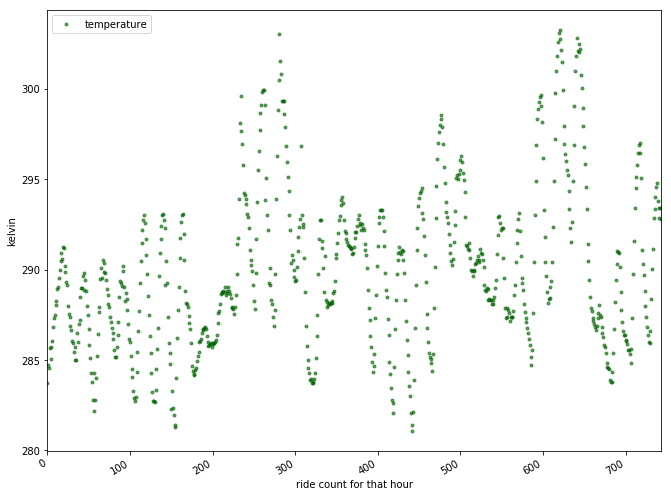

In [42]:
temperature_plot = ['temperature']
axes_temperature = weather_description_df[temperature_plot].plot(marker='.', color="darkgreen",
                                                                 alpha=0.6, 
                                                                 linestyle='None', 
                                                                 figsize=(11, 9), 
                                                                 subplots=True)
for y_axis in axes_temperature:
    y_axis.set_ylabel('kelvin')
for x_axis in axes_temperature:
    x_axis.set_xlabel('ride count for that hour')

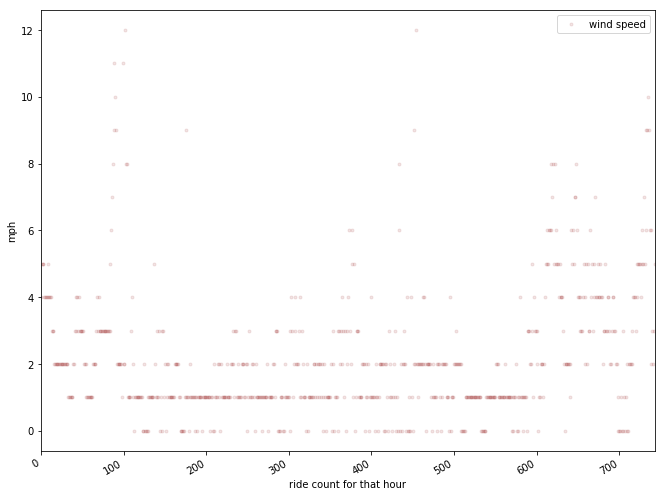

In [43]:
wind_speed_plot = ['wind speed']
axes_wind_speed = weather_description_df[wind_speed_plot].plot(marker='.', color="darkred",
                                                               alpha=0.1, 
                                                               linestyle='None', 
                                                               figsize=(11, 9), 
                                                               subplots=True)
for y_axis in axes_wind_speed:
    y_axis.set_ylabel('mph')
for x_axis in axes_wind_speed:
    x_axis.set_xlabel('ride count for that hour')

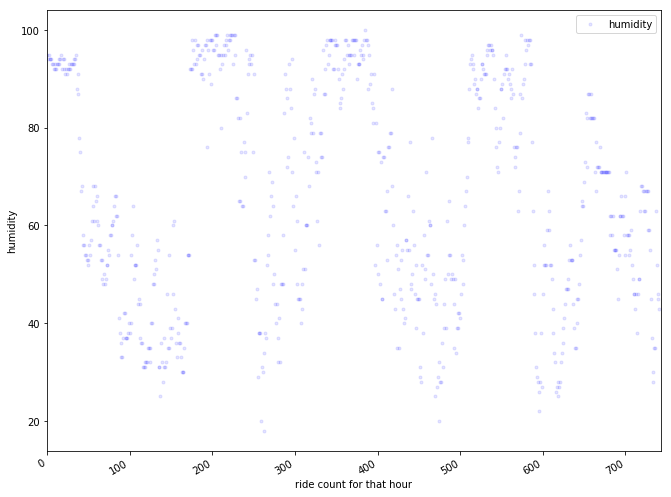

In [44]:
humidity_plot = ['humidity']
axes_humidity = weather_description_df[humidity_plot].plot(marker='.', color="blue",
                                                           alpha=0.1, 
                                                           linestyle='None', 
                                                           figsize=(11, 9), 
                                                           subplots=True)
for y_axis in axes_humidity:
    y_axis.set_ylabel('humidity')
    
for x_axis in axes_humidity:
    x_axis.set_xlabel('ride count for that hour')
    

Include cells that describe the steps in your data analysis.

In [15]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

# Ethics & Privacy

The data set we are analyzing for this project is public data obtained from an open source. The data on its own does not reveal any private information about individual users as well as Uber drivers so we are not as concerned with personal privacy. However, analyzers could still easily extract a lot of information from these data. For instance, analyzing this data set could reveal users’ commute patterns and preferences. Though this does not point to a specific person, it could be information that could be sold to other companies for profit. From this, companies can target users based on their individual preferences. For example, they could distribute advertisements based on these preferences. Or, rideshare apps, like Uber, could take advantage of all these data and deliberately raise prices when the demand is high. 

# Conclusion & Discussion

*Fill in your discussion information here*